## testing for pygenefinder

In [1]:
import sys,os,subprocess,glob,tempfile,time
import re
from importlib import reload
import pandas as pd
pd.set_option('display.max_columns', 14)
pd.set_option('display.max_colwidth', 150)
pd.set_option('display.width', 180)
import numpy as np
import pylab as plt
from Bio.SeqRecord import SeqRecord
from Bio.Seq import Seq
from Bio import SeqIO
import urllib.request
sys.path.append('../')
from pygenefinder import tools, app
datadir = '../pygenefinder/data/'
dbdir = app.dbdir

tempdir = tempfile.gettempdir()

links = {'card':'https://github.com/tseemann/abricate/raw/master/db/card/sequences',
        'resfinder':'https://raw.githubusercontent.com/tseemann/abricate/master/db/resfinder/sequences',
        'vfdb':'https://raw.githubusercontent.com/tseemann/abricate/master/db/vfdb/sequences',
        'sprot':'https://raw.githubusercontent.com/tseemann/prokka/master/db/kingdom/Bacteria/sprot'}

In [2]:
def fetch_sequence_from_url(name='card', path=None):
    """get sequences"""
    
    if path == None:
        path = dbdir
    if not os.path.exists(path):
        os.makedirs(path)

    if name in links:
        url = links[name]
    else:
        print('no such name')
        return
        
    filename = os.path.join(path,"%s.fa" %name)
    if not os.path.exists(filename):
        urllib.request.urlretrieve(url, filename)
    return

fetch_sequence_from_url('resfinder')

In [3]:
def make_target_database(filenames):
    """Make blast dbs of multiple input files"""

    rec=[]
    for n in filenames:
        seqs = list(SeqIO.parse(n,'fasta'))
        for s in seqs:
            s.id = n + '~' + s.id
        rec.extend(seqs)

    targfile = os.path.join(tempdir, 'targets.fasta')
    SeqIO.write(rec, targfile, 'fasta')
    make_blast_database(targfile)
    return

def make_blast_database(filename, dbtype='nucl'):
    """Create a blast db from fasta file"""
    
    cmd = 'makeblastdb'
    #if frozen app
    if getattr(sys, 'frozen', False):
        print ('bundled app in windows')
        cmd = tools.resource_path('bin/makeblastdb.exe')

    cline = '%s -dbtype %s -in %s' %(cmd,dbtype,filename)
    subprocess.check_output(cline, shell=True)
    return

make_target_database(['../test_files/RF15B.fa','../test_files/RF15A.fa'])

## quick prokka type annotation

1. run prodigal 
2. blast output protein seqs 
3. select best hits
4. make genbank from results

* https://www.biostars.org/p/79392/
* https://www.protocols.io/view/week-4-calling-open-reading-frames-with-prodigal-u-gz3bx8n

In [237]:
fetch_sequence_from_url('sprot', path = app.prokkadbdir)

In [9]:
reload(tools)

st=time.time()
#pr = annotate_contigs('../test_annot/contig.fa', 'annot.gbk', threads=10)
pr = app.annotate_contigs('../test_files/RF11.fa', 'annot.gbk', threads=10)
print (time.time()-st)

../test_files/RF11.faa
blasting ORFS to uniprot sequences
blastp -out tempseq_blast.txt -outfmt "6 qseqid sseqid qseq sseq pident qcovs length mismatch gapopen qstart qend sstart send evalue bitscore stitle" -query tempseq.fa -db /home/damien/.config/pygenefinder/prokka/sprot.fa -evalue 0.01 -max_target_seqs 100 -num_threads 10
73.94352173805237


In [21]:
def records_to_fasta(recs, outfile):
    """Write seqrecords features to a fasta file"""

    handle = open(outfile,'w+')
    for rec in recs:
        for feat in rec.features:        
            quals = feat.qualifiers
            SeqIO.write(SeqRecord(Seq(quals['translation']),id=quals['locus_tag']), handle, "fasta")
    return

records_to_fasta(pr, 'test.faa')


## protein sequence clustering

In [ ]:
#cdhit



In [30]:
testseqs = list(SeqIO.parse('test.faa','fasta'))
testseqs = [s.seq for s in testseqs]
from sgt import Sgt
sgt = Sgt(kappa = 10, lengthsensitive = False)
enc = sgt.fit_transform(corpus=testseqs)

In [36]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
pca = PCA(n_components=2)
pca.fit(enc)
X = pca.transform(enc)
print(np.sum(pca.explained_variance_ratio_))

df = pd.DataFrame(data=X, columns=['x1', 'x2'])
df.head()

0.12570902044924762


,x1,x2
0,-0.419230,-0.312565
1,-0.498251,0.063508
2,-0.366993,0.051391
3,-0.463185,-0.163183
4,0.605851,0.025587


In [ ]:
kmeans = KMeans(n_clusters=3, max_iter =300)
kmeans.fit(df)

labels = kmeans.predict(df)
centroids = kmeans.cluster_centers_

fig = plt.figure(figsize=(5, 5))
colmap = {1: 'r', 2: 'g', 3: 'b'}
colors = list(map(lambda x: colmap[x+1], labels))
plt.scatter(df['x1'], df['x2'], color=colors, alpha=0.5, edgecolor=colors)

In [ ]:
reload(tools)
df=tools.genbank_to_dataframe('../amr_results/ecoli_HSP38.gbk')

In [7]:
def find_genes(target, ref='card', ident=90, coverage=75, duplicates=False, threads=2, **kwds):
    """Find ref genes by blasting the target sequences.
    Args:
        target: target blast database
        ref: query sequences to search, e.g. contigs in an assembly
        
    """

    path = os.path.join(dbdir,'%s.fa' %ref)
    #the AMR db is the query for the blast
    queryseqs = list(SeqIO.parse(path,'fasta'))
    print ('blasting %s sequences' %len(queryseqs))
    bl = tools.blast_sequences(target, queryseqs, maxseqs=1, evalue=.01,
                               cmd='blastn', show_cmd=True, threads=int(threads))

    bl['qlength'] = bl.sequence.str.len()
    bl['coverage'] = bl.length/bl.qlength*100
    bl = bl[bl.coverage>coverage]
    bl = bl[bl.pident>ident]
    bl['filename'] = bl.sseqid.apply(lambda x: x.split('~')[0],1)
    bl['id'] = bl.filename.apply(lambda x: os.path.basename(x),1)    
    bl['contig'] = bl.sseqid.apply(lambda x: x.split('~')[1],1)
    try:
        bl['gene'] = bl['qseqid'].apply(lambda x: x.split('~~~')[1],1)
    except:
        bl['gene'] = bl.qseqid

    #remove exact and close duplicates
    print (len(bl))
    bl = bl.sort_values(['contig','bitscore'], ascending=False).drop_duplicates(['contig','sstart','send'])
    print (len(bl))
    if duplicates == False:
        dist = 20
        #x=bl.sort_values(by=["contig","sstart"],ascending=False)
        #print (x[:15][x.columns[:5]])
        #unique = x.sstart.diff().abs().fillna(dist)        
        #bl = bl[unique>=dist]
    cols = ['gene','id','qseqid','pident','coverage','sstart','send','contig','description','filename','bitscore']
    bl = bl[cols]
    return bl

filenames = glob.glob(os.path.join(app.datadir, '*.fa'))
app.make_target_database(filenames[:1])
targfile = os.path.join(app.tempdir, 'targets.fasta')
bl = find_genes(targfile, 'bacteria.16SrRNA', threads=10)


blasting 20336 sequences
blastn -out tempseq_blast.txt -outfmt "6 qseqid sseqid qseq sseq pident qcovs length mismatch gapopen qstart qend sstart send evalue bitscore stitle" -query tempseq.fa -db /tmp/targets.fasta -evalue 0.01 -max_target_seqs 1 -num_threads 10
6000
2999


In [50]:
#find interval overlaps to determine duplicate gene hits inside contig
df = pd.DataFrame({'start': [0,5,10,3,12,13,18,31], 'end':[4,8,13,7,19,16,23,35]})
#df = pd.read_csv('intervals.csv')
print (df)

df=df.sort_values(['start','end'])
df['Group']=((df.start.rolling(window=2,min_periods=1).min()-df.end.rolling(window=2,min_periods=1).max())<0).cumsum()
df

   start  end
0      0    4
1      5    8
2     10   13
3      3    7
4     12   19
5     13   16
6     18   23
7     31   35


,start,end,Group
0,0,4,1
3,3,7,2
1,5,8,3
2,10,13,4
4,12,19,5
5,13,16,6
6,18,23,7
7,31,35,8


In [44]:
from intervaltree import Interval, IntervalTree
ivs = [(1, 2), (4, 7), (5, 9)]
t = IntervalTree(
 Interval(begin, end, "%d-%d" % (begin, end)) for begin, end in ivs
)
t

IntervalTree([Interval(1, 2, '1-2'), Interval(4, 7, '4-7'), Interval(5, 9, '5-9')])

In [ ]:
dist = 20
x=bl.sort_values(by=["contig","sstart"],ascending=False)
print (x[:15][x.columns[:9]])
unique = x.sstart.diff().abs().fillna(dist)
print (unique)
bl = bl[unique>=dist]
#bl

In [4]:
def get_gene_hits(res, gene, filename, db='card'):
    """Get blast hit results"""

    path = os.path.join(dbdir,'%s.fa' %db)
    #dbseqs = SeqIO.to_dict(SeqIO.parse(path,'fasta'))
    dbseqs = tools.fasta_to_dataframe(path)
    dbseqs['gene'] = dbseqs.description.apply(lambda x: x.split('~~~')[1],1)
    #print (dbseqs)
    x = res[res.gene==gene]
   
    found=[]
    contigs = []
    for i,r in x.iterrows():
        name = r.id
        print (name)
        #if name not in isolates: continue
        seqs = SeqIO.to_dict(SeqIO.parse(r.filename,'fasta'))
        node = r.contig
        if r.sstart<r.send:
            s = seqs[node].seq[r.sstart:r.send]
        else:
            s = seqs[node].seq[r.send:r.sstart].reverse_complement()

        s = SeqRecord(id=name,seq=s)
        found.append(s)
        print (name, r.gene, r['coverage'], r['pident'], len(s), node)
        #add card seq
        contigs.append(seqs[node])

    row = dbseqs[dbseqs.gene==gene].iloc[0]
    print (row)
    found.append(SeqRecord(id=row['name'],seq=Seq(row.sequence)))
    seqfile = 'temp.fa'
    SeqIO.write(found, seqfile,'fasta')
    SeqIO.write(contigs,'contigs.fa','fasta')
    #maaft_alignment(seqfile)
    aln = tools.clustal_alignment(seqfile)
    tools.show_alignment(aln)
    #print (aln)
    return


In [ ]:
get_gene_hits(bl, 'dfrA1_9', '../test_files/RF15B.fa', 'resfinder')

In [5]:
def pivot_blast_results(bl):
    x = bl.drop_duplicates(['sstart'])
    m = pd.pivot_table(x, index='id', columns='gene', values='pident')#, aggfunc=np.size)   
    #m = m[m.columns[m.loc['ecoli_k12'].isnull()]]   
    #m = m.drop('ecoli_k12')
    return m

m = pivot_blast_results(bl)
m

gene,aadA24_1,aph(3'')-Ib_2,aph(4)-Ia_1,aph(6)-Id_4,dfrA1_17
id,,,,,
RF15B.fa,98.187,100.0,100.0,99.88,99.577


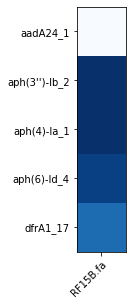

In [9]:
def merge_info(x):
    m=info[['id','stage']]
    x=m.merge(x,right_index=True,left_on='id')
    x=x.set_index(['stage','id'])
    return x

def plot_heatmap(m, fig=None, title=''):

    from matplotlib.gridspec import GridSpec
    l=l=1+int(len(m)/30)
    if fig == None:
        fig = plt.figure()
    gs = fig.add_gridspec(1, l)
    chunks = np.array_split(m,l)
    i=0
    for df in chunks:
        ax = fig.add_subplot(gs[0,i])
        im = ax.imshow(df, cmap='Blues')
        ax.set_xticks(np.arange(len(df.T)))
        ax.set_yticks(np.arange(len(df)))
        ax.set_xticklabels(df.columns)
        ax.set_yticklabels(df.index)
        plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
                 rotation_mode="anchor")
        i+=1
    fig.suptitle(title)
    #plt.tight_layout()
    fig.subplots_adjust(wspace=1.2, bottom=.2)
    return

fig = plt.figure(figsize=(10,5))
plot_heatmap(m.T, fig=fig)

blasting 2617 sequences
blastn -out tempseq_blast.txt -outfmt "6 qseqid sseqid qseq sseq pident qcovs length mismatch gapopen qstart qend sstart send evalue bitscore stitle" -query tempseq.fa -db targets.fasta -evalue 0.1 -max_target_seqs 100 -num_threads 2


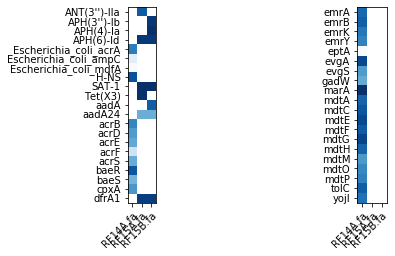

In [10]:
# run in sequence

def run(filenames, db='card'):
    """Run pipeline"""
    
    fetch_sequence_db(db)
    make_blast_database(filenames)
    bl = find_genes('targets.fasta', db)
    #find_gene_hits(bl, 'dfrA1_9', '../test_files/RF15B.fa', db)
    bl.to_csv('%s_results.csv' %db)
    m = pivot_blast_results(bl)
    #print (m)
    plot_heatmap(m.T)
    m.to_csv('%s_matrix.csv' %db)
    return

inpath = '../test_files/'
filenames = glob.glob(os.path.join(inpath,'*.fa*'))
#run(filenames, db='resfinder')
run(filenames, db='card')

In [11]:
def abricate(filename, db='card',id=None):
    
    cmd = '/local/abricate/bin/abricate %s -db %s --mincov 50 --minid 90 > temp.tab' %(filename,db)
    print (cmd)
    subprocess.check_output(cmd, shell=True, executable='/bin/bash')
    df = pd.read_csv('temp.tab',sep='\t')
    id = os.path.basename(filename)
    df['id'] = id
    return df

x = abricate('../test_files/RF15B.fa')

/local/abricate/bin/abricate ../test_files/RF15B.fa -db card --mincov 50 --minid 90 > temp.tab


In [12]:
make_blast_database(['../test_files/RF15B.fa'])
y = find_genes('targets.fasta', 'card', coverage=50, ident=90)

blasting 2617 sequences
blastn -out tempseq_blast.txt -outfmt "6 qseqid sseqid qseq sseq pident qcovs length mismatch gapopen qstart qend sstart send evalue bitscore stitle" -query tempseq.fa -db targets.fasta -evalue 0.1 -max_target_seqs 100 -num_threads 2


0       CTX-M-144
1    ANT(3'')-IIa
2           SAT-1
3           dfrA1
4       APH(6)-Id
5     APH(3'')-Ib
6         Tet(X3)
7       AAC(3)-IV
8       APH(4)-Ia
Name: GENE, dtype: object
12      CTX-M-107
85         aadA24
76           aadA
73          SAT-1
92          dfrA1
7       APH(6)-Id
3     APH(3'')-Ib
4       APH(4)-Ia
Name: gene, dtype: object


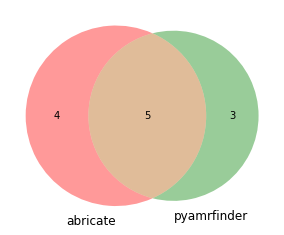

In [13]:
print (x.GENE)
print (y.gene)

from matplotlib_venn import venn2
venn2([set(x.GENE),set(y.gene)],['abricate','pyamrfinder'])

## benchmarking

* https://aac.asm.org/content/63/11/e00483-19
* https://www.ncbi.nlm.nih.gov/pubmed/27365186

## use raw reads

* https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4237778/

In [27]:
def find_reads(idx, file1, file2, bamfile, threads=4):
    
    cmd = 'bwa mem -M -t {t} {i} {f1} {f2} | samtools sort | samtools view -bS - > {o}'.format(i=idx,f1=file1,f2=file2,o=bamfile,t=threads)
    print (cmd)
    #subprocess.check_output(cmd, shell=True)    
    return

bamfile = 'out.bam'
db=os.path.join(dbdir, 'card.fa')
cmd = 'bwa index %s' %db
print (cmd)
subprocess.check_output(cmd, shell=True)

find_reads(db, '../test_reads/RF12A_S17_L001_R1_001.fastq.gz', '../test_reads/RF12A_S17_L001_R2_001.fastq.gz', out, 8)


bwa index /home/farrell/.config/pyamrfinder/db/card.fa
bwa mem -M -t 8 /home/farrell/.config/pyamrfinder/db/card.fa ../test_reads/RF12A_S17_L001_R1_001.fastq.gz ../test_reads/RF12A_S17_L001_R2_001.fastq.gz | samtools sort | samtools view -bS - > out.bam


In [30]:
threads=8
out = 'out.vcf'
cmd = 'bcftools mpileup --skip-indels --threads {t} --output-type v -f {db} --output {o} {b}'.format(db=db,o=out,b=bamfile,t=threads)
print(cmd)

bcftools mpileup --skip-indels --threads 8 --output-type v -f /home/farrell/.config/pyamrfinder/db/card.fa --output out.vcf out.bam
